# Moving Average Model/Process

Moving Average Model (MA) is a commonly used tool in time series analysis. The model relies on the idea of decomposing a time series into three main components: 

1. Trend - The long term direction of the series 
2. Seasonality - Periodic fluctuations in the series, for example, due to seasonal effects 
3. Remaining fluctuations or 'residual', which is defined as the deviation from the trend and seasonality. 

The 'MA' in the model refers to the mean of the 'residual' component.

Mathematically, an MA model can be represented as:

Yt = μ + εt + θ1εt-1 + θ2εt-2 + ... + θqεt-q

Where:
- Yt is the predicted output/forecasted value.
- μ is the mean of the series.
- εt is the white noise at time 't'.
- θ1,θ2,...,θq are the parameters of the model.
- 'q' is the order of the model.

The assumptions of a Moving Average Model:
1. The series is stationary - it has a constant mean and variance over time.
2. The errors (ε's) are independent and identically distributed with zero mean and variance (σ^2).


## Data Generation and Checking Assumptions

Let's generate some data and check whether it meets the assumptions of an MA model.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

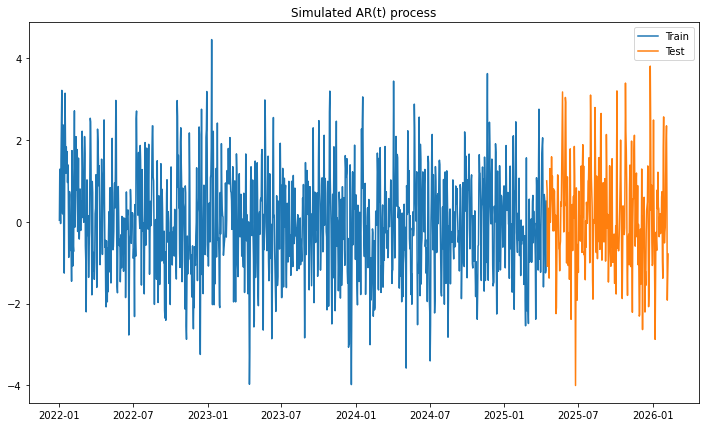

In [7]:
from statsmodels.tsa.arima_process import ArmaProcess

n = 1500
split_point = int(n*0.8)
dates = pd.date_range(start='2022-01-01', periods=n, freq='D')


# Simulate MA(1) process
# the AR parameter sign is reversed when used in ArmaProcess
# the zeroth lag of an MA process is 1
ar = np.array([1])
ma = np.array([1,0.7])

AR_object = ArmaProcess(ar, ma) 
simulated_data = AR_object.generate_sample(nsample=n)

simulated_data = pd.Series(simulated_data, name='Values')
simulated_data.index = dates

simulated_data, test_simulated_data = simulated_data.iloc[:split_point], simulated_data.iloc[split_point:]

plt.figure(figsize=(12, 7))
plt.plot(simulated_data, label='Train')
plt.plot(test_simulated_data, label='Test')
plt.legend()
plt.title('Simulated AR(t) process')
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    """
    Perform Dickey-Fuller test:
    Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
    Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
    """
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(simulated_data)

Results of Dickey-Fuller Test:
Test Statistic                -1.313787e+01
p-value                        1.449609e-24
#Lags Used                     4.000000e+00
Number of Observations Used    1.195000e+03
Critical Value (1%)           -3.435834e+00
Critical Value (5%)           -2.863962e+00
Critical Value (10%)          -2.568059e+00
dtype: float64


In the above code, we first generate some autoregressive data, and then we check for stationarity using the Augmented Dickey-Fuller test (ADF test). If the p-value of the ADF test is less than our chosen significance level (say 0.05), we can reject the null hypothesis of non-stationarity.

### Model Selection for Autoregression

Model selection involves determining the order of the autoregressive model, i.e., how many lagged past values we should use in our prediction. We use the Akaike Information Criterion (AIC) to determine the best model.

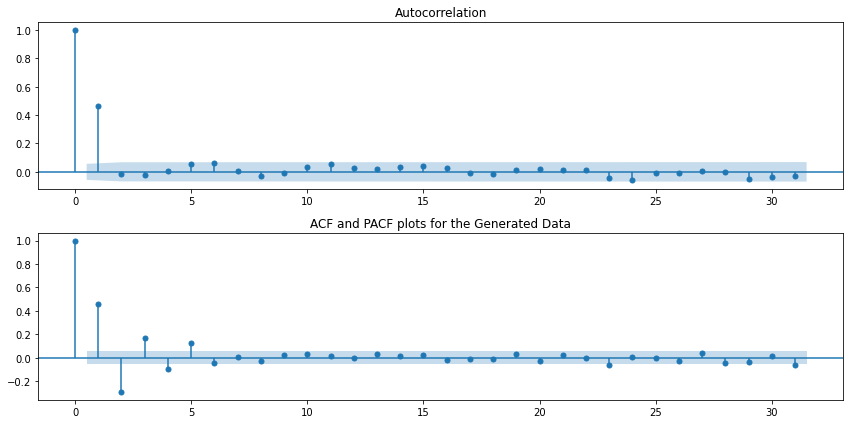

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,figsize=(12,6))
plot_acf(simulated_data, ax=ax[0])  # Identifies the order of AR model
plot_pacf(simulated_data, ax=ax[1])  # Identifies the order of MA model
plt.title('ACF and PACF plots for the Generated Data')
plt.tight_layout()
plt.show()

From the acf/pacf plots, we can see that the time series is most likely an MA(1) given the large spike at lag 1 and the small spikes at the other lags. We can also look at the AIC values for different models and choose the one with the lowest AIC value.

Best model: AR(1), AIC = 3420.460538199074


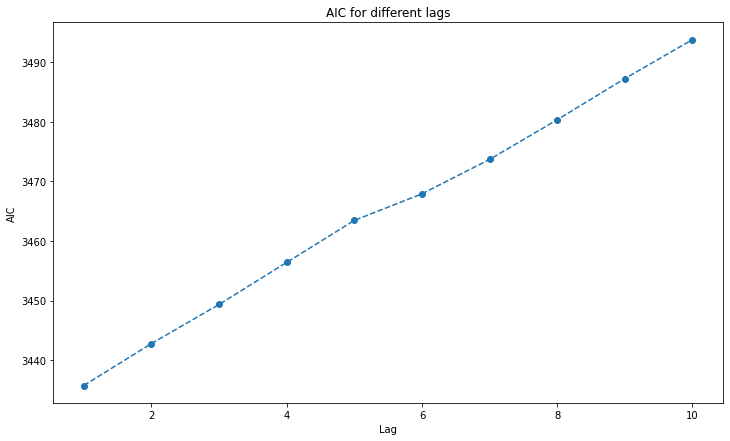

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Define a range of lag values
max_lag = 10
lags = range(1, max_lag + 1)

# Find the best model (the one with the lowest AIC)
best_aic, best_order = np.inf, None

aic = []


for lag in lags:
    model = ARIMA(simulated_data, order=(0,0,lag))
    result = model.fit()

    aic.append(result.bic)

    if result.aic < best_aic:
        best_aic = result.aic
        best_order = lag




print(f'Best model: AR({best_order}), AIC = {best_aic}')

plt.figure(figsize=(12, 7))
plt.plot(lags, aic, marker='o', linestyle='--')
plt.xlabel('Lag')
plt.ylabel('AIC')
plt.title('AIC for different lags')
plt.show()


In [13]:
# Fit the best model
model = ARIMA(endog = simulated_data, order = (0,0,best_order))
result = model.fit()

# Print the summary
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                 1200
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1707.230
Date:                Tue, 19 Mar 2024   AIC                           3420.461
Time:                        13:35:08   BIC                           3435.731
Sample:                    01-01-2022   HQIC                          3426.213
                         - 04-14-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0425      0.049     -0.872      0.383      -0.138       0.053
ma.L1          0.6776      0.021     31.911      0.000       0.636       0.719
sigma2         1.0070      0.042     24.199      0.0

Values.L1 is not far from the coefficient for the lag of 0.8

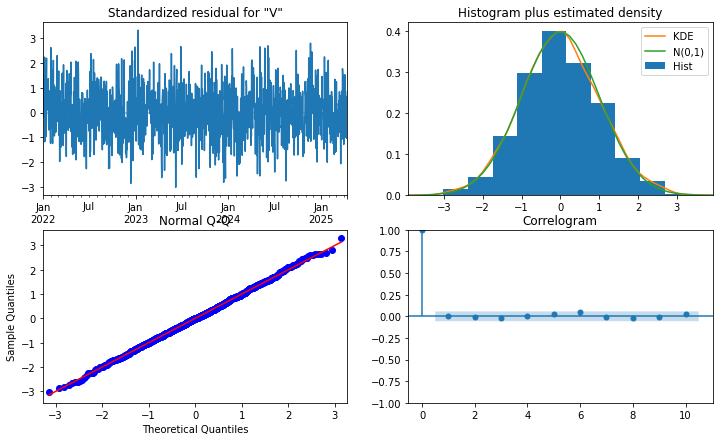

In [17]:
result.plot_diagnostics(figsize=(12, 7))
plt.show()

Produces a 2x2 plot grid with the following plots (ordered clockwise from top left):

- Standardized residuals over time
Residual indeed is the difference between true and predicted value. If there are correlations between residuals - there is information left in the residuals which should be used in computing forecasts. If the residuals have a mean other than zero, then the forecasts are biased. 

- Histogram plus estimated density and Normal Q-Q plot, with Normal reference line show that the residuals are normally distributed.


From documentation
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics.html#statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#step-5-


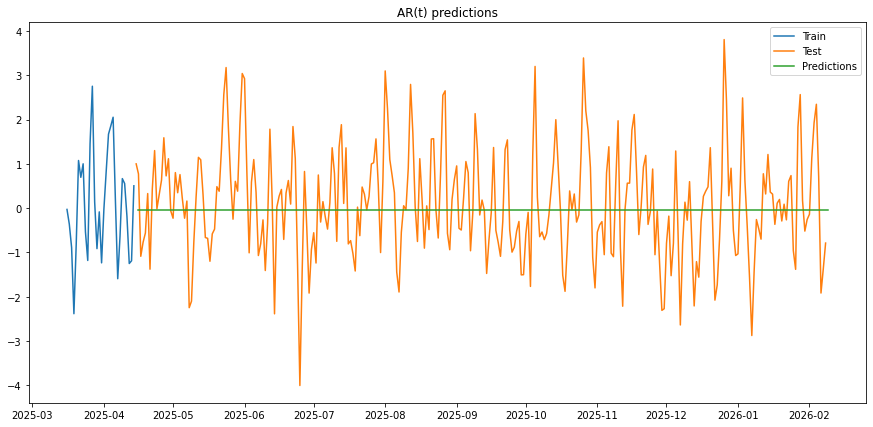

In [20]:
predictions = result.predict(start=split_point + 1, end=n, dynamic=False)

plt.figure(figsize=(15, 7))
plt.plot(simulated_data[-30:], label='Train')
plt.plot(test_simulated_data, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.title('MA(t) predictions')
plt.show()

The model produces a relatively straight line.

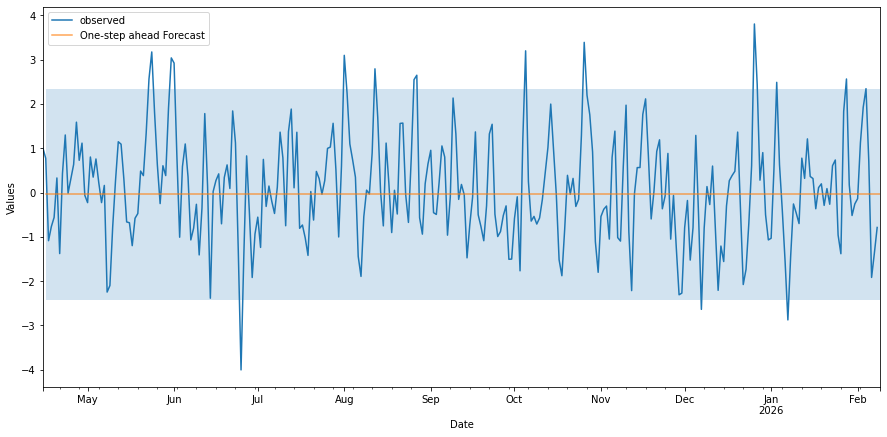

In [31]:
pred = result.get_prediction(start=split_point + 1, end=n, dynamic=False)
pred_ci = pred.conf_int()

ax = test_simulated_data.plot(label='observed', figsize=(15, 7))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Values')

plt.legend()
plt.title('MA(t) predictions with confidence intervals')
plt.show()

### Compare to naive forecast

In [22]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_simulated_data, predictions)

# Naive forecast
# The naive forecast is the mean of the training set(the seen values)
naive_mse = mean_squared_error(test_simulated_data, [np.mean(simulated_data)]*len(test_simulated_data))

print(f'MSE: {mse}')
print(f'Naive MSE: {naive_mse}')

MSE: 1.4831972072611965
Naive MSE: 1.4832792709181482
